<a href="https://colab.research.google.com/github/BillGrieser/Portfolio/blob/master/Named_Entity_Recognition_with_Jeopardy_clues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition with Jeopardy! Clues

In this project uses Keras with a TensorFlow backend to build a network to perform Named Entity Recognition (NER) on sentences.

The trained model is then used to analyze some clues from the Jeopardy! TV program sraped from a fan web site.

The predictor function uses an approach where sentences are predicted in both directions, and results of one prediction feeds into the next, until the predictions agree forward and backward.

The model features Embedding layers feeding LSTM layers, that then feed a CRF output layer.

Bill Grieser

---

## The Data

The data is composed of over 40000 sentences. It is organized so that one row of data is one word in a sentence. It is in order by sentence. Each word is labelled with a tag indicating whether it is part of a named entity and if so, what kind. 

Words that are not part of named entities are tagged with `O`. Tags for words that are part of a named entiy start with either `B-` if the work begins a nemaed entity, or `I-` if the word continues a named entity. 


| Word Tag        |  Meaning           |
| :------------- |:-------------:|
|`B-geo`      |Begin Geographical Entity|
|`B-org`      |Begin Organization|
|`B-per`      |Begin Person|
|`B-gpe`      |Begin Geopolitical Entity|
|`B-tim`      |Begin Time|
|`B-art`      |Begin Artifact|
|`B-eve`      |Begin Event|
|`B-nat`      |Begin Natural Phenomena|
|`I-geo`      |Continue Geographical Entity|
|`I-org`      |Continue Organization|
|`I-per`      |Continue Person|
|`I-gpe`      |Continue Geopolitical Entity|
|`I-tim`      |Continue Time|
|`I-art`      |Continue Artifact|
|`I-eve`      |Continue Event|
|`I-nat`      |Continue Natural Phenomena|
|`O`      |Other (not a named entity)|

### Success Criteria

A set of labeled data is being held out from the training, and this is used to evaluate the trained model.

To experiment with the trained model with unseen data, clues from the TV show _Jeopardy!_ were scraped from a fan website using Beautiful Soup and are fed into the model.

### Data Sources:

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/home

which was extracted from the Groningen Meaning Bank.

For the _Jeopardy!_ clues:  
http://j-archive.com/

## Setup
Get the data and install the CRF implementation.

In [0]:
!git clone https://github.com/BillGrieser/Portfolio.git
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Cloning into 'Portfolio'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 39 (delta 10), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (39/39), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_swze3sl
  Running setup.py bdist_wheel for keras-contrib ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-gji947nu/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


#### Includes:

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import tqdm

#### Set Parameters for this run

These constants set values used to control the kind of model built. FIT, when True, indicates that a new model should be fitted with the weights stored in the weight file. If FIT is False, the weight file will be read into a predictor model instead of fitting a new model. The values for the number of nodes and the minimum number of occurrences for words to include them in the lexicon were determined by experimenting with different settings and finding something reasonable.

In [0]:
#
# Set to True to fit a new model; False to read pre-trained weisght from the 
# WEIGHT_FILE
#
FIT_MODEL = True
WEIGHT_FILE = "model_weights_300_50_22_min8_e7_b128.h5"
WEIGHT_FILE_init = ""  # Starting weights for additional training

MIN_OCCURRENCES = 8   # Discard words seen less often than this
N_WORD_EMBEDDING_NODES = 300
N_TAG_EMBEDDING_NODES = 50
N_HIDDEN_NODES = 22

EPOCHS = 7
INITIAL_EPOCH = 0
BATCH_SIZE = 256
INPUT_NER_FILE = os.path.join('Portfolio', 'data', 'ner_dataset.csv')
print("Run parameters set.")

Run parameters set.


## Prepare the data

We want to process the data one sentence at a time; however, the data is originally one row per word. Assemble the words into sentences and then split the sentences into a train and test set.

In [0]:
import sklearn.model_selection 

data = pd.read_csv(INPUT_NER_FILE, encoding='latin1')
data = data.fillna(method="ffill")

# Find all the unique sentence IDs in the input data using numpy.unique, which
# also counts the number of occurrences of each value.
sentence_ids, sl = np.unique(data['Sentence #'], return_counts=True)

max_sentence_length = max(sl)
print ("Number of unique sentence IDs:", len(sentence_ids))
print ("Max sentence length:", max_sentence_length)
del sl

# Split the IDs
X_train_ids, X_test_ids = sklearn.model_selection.train_test_split(
    sentence_ids, test_size=0.1, random_state=3)

# Split the original NER data by sentence ID
X_train = data[data['Sentence #'].isin(X_train_ids[:])]
X_test = data[data['Sentence #'].isin(X_test_ids[800:1000])] # Can limit the size of test data here
print("Number of words in the test set:", len(X_test))

Number of unique sentence IDs: 47959
Max sentence length: 104
Number of words in the test set: 4423


#### Index the words and tags; filter out infrequent words
Turn every unique word and tag into a number for the model.

In [0]:
# Build a lexicon from the training data, including the count of each word
words, wc = np.unique(X_train['Word'], return_counts=True)

# Turn the word list and counts into a dict
words = {x[0]: x[1] for x in zip(words, wc)}
del wc

print('Filtering out words with less than {} occurrences out of {} unique words in the training data.'.format(MIN_OCCURRENCES, len(words)))

# Sort the words by count, highest to lowest; filter out infrequent words
lex_words = sorted([w for w in words if words[w] >= MIN_OCCURRENCES], key=lambda x: words[x], reverse=True)

# Make a number for each word, starting at 2 (1 is unknown and 0 is pad)
word2index = {x[1]: x[0]+2 for x in enumerate(lex_words)}
index2word = {x[1]: x[0] for x in word2index.items()}
index2word[0] = ''
index2word[1] = '<UNK>'

# Do the same for tags
tags = np.unique(X_train['Tag'])
tag2index = {x[1]: x[0]+2 for x in enumerate(tags)}
index2tag = {x[1]: x[0] for x in tag2index.items()}
index2tag[0] = ''
index2tag[1] = '<UNK>'

print("Using {} words and {} tags, including <UNK> and pad.".format(len(index2word), len(index2tag)))

Filtering out words with less than 8 occurrences out of 33619 unique words in the training data.
Using 7725 words and 19 tags, including <UNK> and pad.


#### Build test and train datasets, one row per sentence

Convert the train and test datasets in the one-row-per-word format into one-row-per-sentence dataframes. The resulting dataframe will use the sentence ID as the index, and will contain four columns:
* **Words**: A list with the tokenized words of the sentence.
* **Word Indices**: A list of integer indices corresponding to the workds
* **Tags**: A list of the named-entity tags corresponding to the words
* **Tag Indices**: A list of integer indices corresponding to the tags

In [0]:
# Convert the word to an index, or the unknown index id the word is not in the lexicon
get_index_for_word = lambda x: word2index[x] if x in word2index else 1

# Do the same for a tag
get_index_for_tag = lambda x: tag2index[x] if x in tag2index else 1

# Create functions used to aggregate input rows into sentence rows, looking up
# the index for a word/tag if needed. Pad each list on both ends with the UNKNOWN character.
def agg_word_tokens(x):
    return [index2word[1]] + list(x) + [index2word[1]]

def agg_word_indices(x):
    return [1] + [get_index_for_word(w) for w in list(x)] + [1]

def agg_tag_tokens(x):
    return [index2tag[1]] + list(x) + [index2tag[1]]

def agg_tag_indices(x):
    return [1] + [get_index_for_tag(t) for t in list(x)] + [1]

# 
# Given a dataframe in the input NER format, make a dataframe where each row is a sentence
# using the word and tag indices determined above. Each sentence has a pad at each end
def make_sentence_df(data_df):
    
    group = data_df.groupby('Sentence #')
                            
    words_df = group['Word'].aggregate([agg_word_tokens, agg_word_indices])
    tag_df = group['Tag'].aggregate([agg_tag_tokens, agg_tag_indices])
    
    sentence_df = words_df.join(tag_df).copy()
    sentence_df.columns = ['Words', 'Word Indices', 'Tags', 'Tag Indices']        
    
    return sentence_df

Make test and train dataframes with one row per sentence. Note that there is an unknown word/tag on both the beginning and end of each sentence. 

In [0]:
# Convert the train and test splits into sentence-oriented dataframes
X_train_sentences = make_sentence_df(X_train)
X_test_sentences = make_sentence_df(X_test)    

X_train_sentences.head(3)

,Words,Word Indices,Tags,Tag Indices
Sentence #,,,,
Sentence: 1,"[<UNK>, Thousands, of, demonstrators, have, ma...","[1, 1173, 5, 1131, 17, 1881, 231, 473, 7, 528,...","[<UNK>, O, O, O, O, O, O, B-geo, O, O, O, O, O...","[1, 18, 18, 18, 18, 18, 18, 4, 18, 18, 18, 18,..."
Sentence: 10,"[<UNK>, Iranian, officials, say, they, expect,...","[1, 321, 43, 25, 56, 1826, 7, 739, 1027, 7, 46...","[<UNK>, B-gpe, O, O, O, O, O, O, O, O, O, O, O...","[1, 5, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,..."
Sentence: 100,"[<UNK>, Helicopter, gunships, Saturday, pounde...","[1, 1, 4601, 93, 5069, 279, 5035, 6, 2, 4751, ...","[<UNK>, O, O, B-tim, O, O, O, O, O, B-geo, O, ...","[1, 18, 18, 9, 18, 18, 18, 18, 18, 4, 18, 18, ..."


## Define the Model

This model uses two LSTM layers in parallel, one running forward and the other backward. It accepts as input sentences converted a list of word indices, and two other inputs: For each word, the index of the tag preceding the word and the index of the tag following the word.   

There is a Dropout layer as a countermeasure to overfitting. We are using an implementation of Conditional Random Fields (CRF) from the `keras.contrib` package to help with the sequence prediction task.

In [0]:
from keras.models import Model
from keras.layers import Input, Concatenate, LSTM, TimeDistributed, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from sklearn.metrics import accuracy_score, f1_score

"""
Create a model using the input sizes and options. This will accept as input words, 
preceeding tags, and folllowing tags and will predict the tags matching the words. It has 
two separate LSTM layers, one running in each direction.
"""
def create_model(seq_input_len, n_word_input_nodes, n_tag_input_nodes, n_word_embedding_nodes,
                 n_tag_embedding_nodes, n_hidden_nodes, stateful=False, batch_size=None):
    
    #Layers 1
    word_input = Input(batch_shape=(batch_size, seq_input_len), name="Word_Input")
    pre_tag_input = Input(batch_shape=(batch_size, seq_input_len), name="PreTag_Input")
    post_tag_input = Input(batch_shape=(batch_size, seq_input_len), name="PostTag_Input")

    #Layers 2
    word_embeddings_pre = Embedding(name="Word_Embedding_Pre", input_dim=n_word_input_nodes,
                                output_dim=n_word_embedding_nodes, 
                                mask_zero=True)(word_input) #mask_zero will ignore 0 padding
    
    word_embeddings_post = Embedding(name="Word_Embedding_Post", input_dim=n_word_input_nodes,
                                output_dim=n_word_embedding_nodes, 
                                mask_zero=True)(word_input) #mask_zero will ignore 0 padding
    
    #Output shape = (batch_size, seq_input_len, n_word_embedding_nodes)
    pre_tag_embeddings = Embedding(name="Tag_Embedding_Pre", input_dim=n_tag_input_nodes,
                               output_dim=n_tag_embedding_nodes,
                               mask_zero=True)(pre_tag_input) 
    #Output shape = (batch_size, seq_input_len, n_tag_embedding_nodes)
    
    #Layer 3
    post_tag_embeddings = Embedding(name="Tag_Embedding_Post", input_dim=n_tag_input_nodes,
                               output_dim=n_tag_embedding_nodes,
                               mask_zero=True)(post_tag_input) 
    
    #Output shape = (batch_size, seq_input_len, n_tag_embedding_nodes)
    
    #Layer 4
    pre_merged_embeddings = Concatenate(axis=-1)([word_embeddings_pre, pre_tag_embeddings])
    post_merged_embeddings = Concatenate(axis=-1)([word_embeddings_post, post_tag_embeddings])
    
    #Layer 5
    pre_hidden_layer = LSTM(name="LSTM_Pre", units=n_hidden_nodes, return_sequences=True,
                        recurrent_dropout=0.1, 
                        stateful=stateful )(pre_merged_embeddings) 

    post_hidden_layer = LSTM(name="LSTM_Post", units=n_hidden_nodes, return_sequences=True,
                        recurrent_dropout=0.1, 
                        stateful=stateful, go_backwards=True)(post_merged_embeddings) 

    #Layer 6
    pre_dense_layer = TimeDistributed(Dense(units=n_hidden_nodes, 
                                         activation='tanh'), name="TimeDist_Pre")(pre_hidden_layer)
    post_dense_layer = TimeDistributed(Dense(units=n_hidden_nodes, 
                                         activation='tanh'), name="TimeDist_Post")(post_hidden_layer)
    
    # Layer 7
    merged_dense_layer = Concatenate(axis=-1)([pre_dense_layer, post_dense_layer])
    
    # Layer 8
    dropout_layer = Dropout(0.5)(merged_dense_layer)
    
    # Output Layer
    crf = CRF(n_tag_input_nodes)
    output_layer = crf(dropout_layer)
    
    #Specify which layers are input and output, compile model with loss and optimization functions
    model = Model(inputs=[word_input, pre_tag_input, post_tag_input], outputs=output_layer)
    model.compile(loss=crf_loss,
                  optimizer='rmsprop', metrics=[crf_accuracy])
    
    return model

Using TensorFlow backend.


In [0]:
model = create_model(seq_input_len=max_sentence_length, 
                     n_word_input_nodes=len(index2word), 
                     n_tag_input_nodes=len(index2tag),
                     n_word_embedding_nodes=N_WORD_EMBEDDING_NODES,
                     n_tag_embedding_nodes=N_TAG_EMBEDDING_NODES,
                     n_hidden_nodes=N_HIDDEN_NODES)

#### Visualize the model

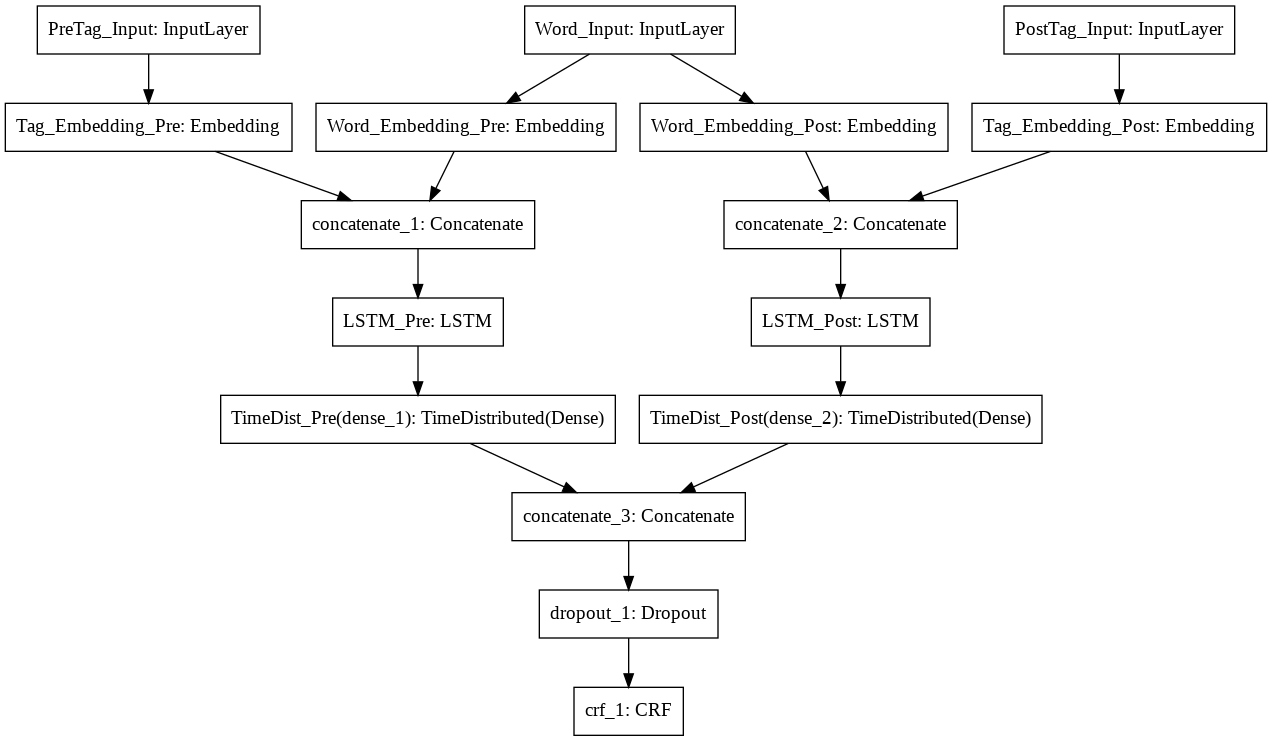

In [0]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
plot_model(model, to_file='model.png')
Image('model.png', width=900, embed=True) 


## Train the Model

We will use Keras to train the model with the training sentences. This can take a while, so we also have the option to load weights from a previous training run.

In [0]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
padding= 'post'

if FIT_MODEL == True:
    
    # Fit the model. Three inputs: (All converted to indices in the lexicon/tag list):
    #    A list of words in the sentences
    #    A list of tags for the preceeding word
    #    A list of tags for the succeeeding word
    #
    if WEIGHT_FILE_init != '':
        print("Initializing weights before fitting from:", WEIGHT_FILE_init)
        model.load_weights(WEIGHT_FILE_init)
    
    # All padded to the max sentence length
    train_history = model.fit(x=[pad_sequences(X_train_sentences['Word Indices'].apply(lambda w: w[1:-1]),
                                padding=padding, maxlen=max_sentence_length), \
                 pad_sequences(X_train_sentences['Tag Indices'].apply(lambda t: t[:-2]), 
                               padding=padding, maxlen=max_sentence_length), \
                 pad_sequences(X_train_sentences['Tag Indices'].apply(lambda t: t[2:]), 
                               padding=padding, maxlen=max_sentence_length)], \
              y=to_categorical(pad_sequences(X_train_sentences['Tag Indices'].apply(lambda t: t[1:-1]), 
                                             padding=padding, maxlen=max_sentence_length), \
                num_classes=len(index2tag)), \
              batch_size=BATCH_SIZE, validation_split=0.05, 
              epochs=EPOCHS, initial_epoch=INITIAL_EPOCH, verbose=1)
    
    print("Saving weights . . .")
    model.save_weights(WEIGHT_FILE) #Save model
    print("Done saving weights.")
    
else:
    print("Using pre-trained weights.")

Train on 41004 samples, validate on 2159 samples
Epoch 1/7
41004/41004 [==============================] - 169s 4ms/step - loss: 14.3452 - crf_accuracy: 0.8261 - val_loss: 14.2864 - val_crf_accuracy: 0.8938
Epoch 2/7
41004/41004 [==============================] - 165s 4ms/step - loss: 13.7843 - crf_accuracy: 0.9289 - val_loss: 14.0747 - val_crf_accuracy: 0.9642
Epoch 3/7
41004/41004 [==============================] - 165s 4ms/step - loss: 13.6696 - crf_accuracy: 0.9614 - val_loss: 14.0345 - val_crf_accuracy: 0.9704
Epoch 4/7
41004/41004 [==============================] - 165s 4ms/step - loss: 13.6364 - crf_accuracy: 0.9691 - val_loss: 14.0171 - val_crf_accuracy: 0.9753
Epoch 5/7
41004/41004 [==============================] - 165s 4ms/step - loss: 13.6205 - crf_accuracy: 0.9728 - val_loss: 14.0106 - val_crf_accuracy: 0.9769
Epoch 6/7
41004/41004 [==============================] - 166s 4ms/step - loss: 13.6105 - crf_accuracy: 0.9751 - val_loss: 14.0054 - val_crf_accuracy: 0.9788
Epoch 7/7

#### Show loss history during training

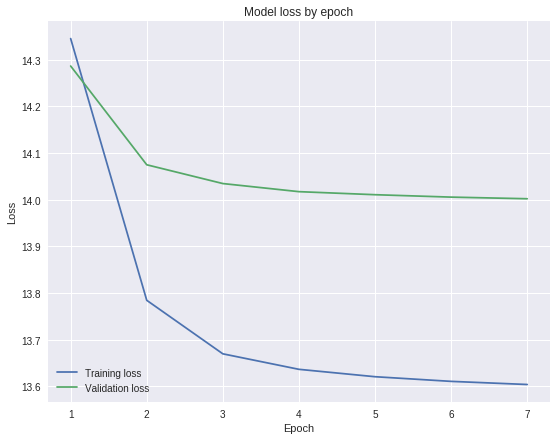

In [0]:
img_file = os.path.join("Portfolio", "weights", "training_loss.png")
if FIT_MODEL == True:
    # Plot training & validation loss values
    plt.figure(1, figsize=(9,7))
    plt.plot([x+1 for x in range(len(train_history.history['loss']))], train_history.history['loss'])
    plt.plot([x+1 for x in range(len(train_history.history['val_loss']))], train_history.history['val_loss'])
    plt.title('Model loss by epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='lower left')
    plt.savefig(img_file)
    try:
      plt.show()
    except:
      pass
    plt.close()
else:
    display(Image(img_file, embed=True))
    


## Make Predictions

### Iterative predictor function

This function is given a list of words converted to their indices in the lexicon. It predicts the tag for each word in the list using model 2. Each prediction uses the predicted next and predicted previous tag as part of the prediction. This function processes the words in both a forward and reverse direction until either both directions predict the same tags or the maximim number of tries is reached, in which case, the forward prediction is returned. In testing, some sentences agreed right away, others took 2 or 3 iterations to match, and the rest did not match after 10 tries, so the max iterations used is 4; if they haven't matched by then the liklihood of matching with more iterations is low.

In [0]:
"""
Given a list of word indices, make a prediction for the tags. Make a prediction processing the indices
both forward and back. Keep trying until the forward and reverse predictions match, or until a set number of
tries has been made.
"""
def predict_from_word_indices(word_indices, model):
    
    # Initially none are known
    reverse_preds = [1] * (2 + len(word_indices))
    forward_preds = [1] * (2 + len(word_indices))
    
    done = False
    counter = 0
    
    # Loop until either the forward and backward predictions agree or a set number of tries is reached
    while not done:
        
        model.reset_states()
       
        # Lamda to simulate enumerate, but in reverse order
        reverse_enumerate = lambda lst: zip(range(len(lst)-1, -1, -1), reversed(lst))
        
        for idx, cur_word in reverse_enumerate(word_indices):
            
            # cur_word and prev_tag are just integers, but the model expects an input array
            # with the shape (batch_size, seq_input_len), so prepend two dimensions to these values
            pred_onehot = model.predict(x=[np.array(cur_word)[None,None],
                                          np.array(forward_preds[idx])[None,None], 
                                          np.array(reverse_preds[idx+2])[None,None]])[0]
            pred_tag = np.argmax(pred_onehot, axis=-1)[0]
            
            # Add the pred tag to its place in the reverse preds; add 1 to idx to account for pad
            reverse_preds[idx+1] = pred_tag
         
        model.reset_states()
        
        # Use the revsersed predictions to find a value for the following tag
        # and predict the tags going forward
        for idx, cur_word in enumerate(word_indices):
            
            pred_onehot = model.predict(x=[np.array(cur_word)[None,None],
                                          np.array(forward_preds[idx])[None,None], 
                                          np.array(reverse_preds[idx+2])[None,None]])[0]
            pred_tag = np.argmax(pred_onehot, axis=-1)[0]
            
            # Add the pred tag to its place in the forward preds; add 1 to idx to account for pad
            forward_preds[idx+1] = pred_tag
            
        counter += 1
        if (reverse_preds == forward_preds) or (counter >= 4):
            done = True
            
    # Turn into human readable
    tags = [index2tag[x] for x in forward_preds[1:-1]]
    
    #print("Reverse:", tagsr)
    #print("Forward:", tags)
    #print("Counter:", counter)
    
    return tags
  
print("predict_from_word_indices() defined.")

predict_from_word_indices() defined.


### Predict the test data

In [0]:
# Make a prediction model that accepts one word at a time. It is stateful so it remembers
# previous inputs until explicity told to start over
model_predict = create_model(seq_input_len=1, # Predict one word at a time
                     n_word_input_nodes=len(index2word), 
                     n_tag_input_nodes=len(index2tag),
                     n_word_embedding_nodes=N_WORD_EMBEDDING_NODES,
                     n_tag_embedding_nodes=N_TAG_EMBEDDING_NODES,
                     n_hidden_nodes=N_HIDDEN_NODES,
                     stateful=True, batch_size=1)
    
# Load the model with the weights from the training model
if FIT_MODEL == True:
    model_predict.set_weights(model.get_weights())
else:
    # Not fitting, load a pre-made weight file
    print("Loading weights . . .")
    model_predict.load_weights(os.path.join("Portfolio", "weights", WEIGHT_FILE)) 
    print("Done loading weights.")
    
# Update the test dataframe with the predicted tags for each sentence. Include 
# the padding characters so the tag lists for the
# same sentence are the same length
predictor = lambda x: [index2tag[1]] + predict_from_word_indices(x[1:-1], model_predict) + [index2tag[1]]
predictions = []

for idx in tqdm.trange(len(X_test_sentences)):
  predictions.append(predictor(X_test_sentences['Word Indices'].iloc[idx]))

#X_test_sentences['Predicted Tags'] = X_test_sentences['Word Indices'].apply(predictor)
X_test_sentences['Predicted Tags'] = predictions

100%|██████████| 200/200 [04:10<00:00,  1.51s/it]


### Evaluate model accuracy against the held-out test data

In [0]:
# Build lists of predicted tags for this model
all_true = X_test_sentences['Tags'].apply(lambda x: x[1:-1]).sum()
all_pred = X_test_sentences['Predicted Tags'].apply(lambda x: x[1:-1]).sum()

acc = accuracy_score(all_true, all_pred)
f1 = f1_score(all_true, all_pred, average='weighted')
print("Model vs. the held-out test data:\n    Accuracy: {:.3f} \n    Weighted F1 score: {:.3f}". \
      format(acc, f1))

Model vs. the held-out test data:
    Accuracy: 0.944 
    Weighted F1 score: 0.944


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Show Classification Report

In [0]:
from sklearn.metrics import classification_report

print("Classification report for the model:")
print(classification_report(all_true, all_pred))

Classification report for the model:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         3
       B-eve       0.00      0.00      0.00         1
       B-geo       0.81      0.90      0.85       147
       B-gpe       0.94      0.94      0.94        80
       B-org       0.50      0.61      0.55        77
       B-per       0.51      0.83      0.63        66
       B-tim       0.89      0.87      0.88        83
       I-art       0.00      0.00      0.00         6
       I-eve       0.00      0.00      0.00         1
       I-geo       0.81      0.69      0.75        32
       I-gpe       0.00      0.00      0.00         2
       I-org       0.61      0.43      0.50        79
       I-per       0.76      0.82      0.79        74
       I-tim       0.87      0.54      0.67        24
           O       0.99      0.98      0.98      3748

   micro avg       0.94      0.94      0.94      4423
   macro avg       0.51      0.51      0.50

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Helper Function for test data prediction

This function accepts the name of a sentence in the test data and runs a prediction for it against the model and compares it to the actual label for each word.

In [0]:
def compare_pred(name):
    """
    Take the name of a sentence in the test dataframe and show a comparison between
    the actual and predicted tags for each word.
    """
    actual_words = X_test_sentences.loc[name]['Words'][1:-1]
    actual_tags = X_test_sentences.loc[name]['Tags'][1:-1]
    pred_tags = X_test_sentences.loc[name]['Predicted Tags'][1:-1]
    print(65 * '-')
    print("Word".ljust(14), ' ', "Actual Tag".ljust(12), ' ', "Model Pred".ljust(12))
    print(65 * '-')
    for i in range(len(actual_words)):
        print(actual_words[i].ljust(14)[:14], ' ', actual_tags[i].ljust(12), ' ', pred_tags[i].ljust(12))

#### Compare some sentences from the held-out test data

In [0]:
# Run some comparisons: Truth vs. Model
compare_pred(X_test_sentences.index[0])
print()
compare_pred(X_test_sentences.index[10])
print()
compare_pred(X_test_sentences.index[90])
print()
compare_pred(X_test_sentences.index[150])

-----------------------------------------------------------------
Word             Actual Tag     Model Pred  
-----------------------------------------------------------------
Indian           B-gpe          B-gpe       
Prime            O              B-per       
Minister         O              O           
Manmohan         B-per          B-per       
Singh            I-per          I-per       
is               O              O           
to               O              O           
hold             O              O           
talks            O              O           
with             O              O           
Kashmiri         B-gpe          B-gpe       
political        O              O           
leaders          O              O           
on               O              O           
Saturday         B-tim          B-tim       
to               O              O           
try              O              O           
to               O              O           
stop         

## Run with Jeopardy! Data

There is a fan site for the Jeopardy television program, where volunteers transcribe each show a few days after it airs, and the game boards are reproduced on the web site http://j-acrchive.com . This was the source of novel data to feed to the prediction model to see what happens. Beatuful Soup 4 was used to scrape the clues for a game into a csv file. Each game has an ID assigned by the website and individual games can be scraped. A recent game was selected at random. 

#### Web page scraping code

In [0]:
from bs4 import BeautifulSoup
import requests

'''
Create a csv file containing the clues for an input Jeopardy! game id, by scraping the
fan site www.j-archive.com.
'''
def scrape_jeopardy_game(game_id):
    url = r'http://j-archive.com/showgame.php?game_id={0}'.format(GAME_ID)

    # Get the web page for the game
    r  = requests.get(url)
    data = r.text

    # Make a soup object
    soup = BeautifulSoup(data, 'html5lib')

    extract = []
    clues = soup.find_all(class_='clue_text')

    for clue in clues: 
        id = clue.attrs['id']
        id = id[5:] if id.startswith('clue_') else id
        extract.append((GAME_ID + '_' + id, id, clue.text + '.'))
    
    df = pd.DataFrame(extract, columns=['id', 'clue id', 'clue'])
    df.set_index('id', inplace=True)
    df.to_csv("j-game-{}.csv".format(GAME_ID))

GAME_ID = '5949'

# Either scrape a game or use one previously saved
#scrape_jeopardy_game(GAME_ID)

# Read the Jeaopardy! clues into a dataframe
jdf = pd.read_csv(os.path.join('Portfolio', 'data', 'j-game-{}.csv'.format(GAME_ID)), index_col=0)

In [0]:
# Display some clues from the selected Jeopardy! game
pd.set_option('max_colwidth', int(max_sentence_length))
pd.set_option('max_rows', jdf.shape[0])

jdf[['clue']].tail()

,clue
id,
5949_DJ_3_5,The title of this Netflix show about an early 20th c. British street gang that gets rich refers to t...
5949_DJ_4_5,"As you can guess, the Victoria Falls Bridge over this African river has amazing views."
5949_DJ_5_5,"This long word follows ""minister"" to designate a diplomat with full power to represent his government."
5949_DJ_6_5,Emflaza decreases inflammation to fight the Duchenne type of this 2-word disease.
5949_FJ,"The father of this future composer was a French teacher at the Warsaw Lyceum, where the child would ..."


#### Print Prediction functions
These are helper functions which take ordinary sentences and run them through the model. This uses the Natural Language Toolkit to parse the sentences into words.

In [0]:
import nltk
nltk.download('punkt')

"""
Take a sentence in a string, tokenize it and use the model to predict word tags. 
"""
def predict_sentence(sentence, model=model_predict):
    
    # Tokenize the sentence
    sent_tok = nltk.word_tokenize(sentence)
    
    # Turn into indices
    sent_indices = [get_index_for_word(w) for w in sent_tok]
    
    tags = predict_from_word_indices(sent_indices, model) 
    
    return list(zip(sent_tok, tags))

'''
Take the output of predict_sentence and print
'''
def print_prediction(pred_list):
    
    print(49 * '-')
    print("Word".ljust(14), ' ',"Model Pred".ljust(12))
    print(49 * '-')
    
    for pred in pred_list:
        print(pred[0].ljust(14)[:14], ' ', pred[1].ljust(12))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Show predictions for some Jeopardy! clues

In [0]:
print_prediction(predict_sentence(jdf.loc['5949_FJ'].clue))
              

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
The              O           
father           O           
of               O           
this             O           
future           O           
composer         O           
was              O           
a                O           
French           B-gpe       
teacher          O           
at               O           
the              O           
Warsaw           B-org       
Lyceum           I-org       
,                O           
where            O           
the              O           
child            O           
would            O           
later            O           
attend           O           
.                O           


In [0]:
print_prediction(predict_sentence(jdf.loc['5949_DJ_4_3'].clue))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
The              O           
3                O           
boroughs         O           
in               O           
New              B-geo       
York             I-geo       
City             I-geo       
's               O           
Triborough       B-geo       
Bridge           I-geo       
are              O           
Manhattan        B-geo       
,                O           
the              O           
Bronx            B-org       
&                I-org       
this             O           
.                O           


In [0]:
print_prediction(predict_sentence(jdf.loc['5949_DJ_4_5'].clue))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
As               O           
you              O           
can              O           
guess            O           
,                O           
the              O           
Victoria         B-geo       
Falls            I-geo       
Bridge           I-geo       
over             O           
this             O           
African          B-gpe       
river            O           
has              O           
amazing          O           
views            O           
.                O           


In [0]:
print_prediction(predict_sentence(jdf.loc['5949_DJ_2_2'].clue))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
Read             B-per       
all              O           
about            O           
it               O           
!                O           
In               O           
2013             B-tim       
this             O           
Amazon           B-org       
founder          O           
bought           O           
the              O           
Washington       B-geo       
Post             B-org       
.                O           


In [0]:
print_prediction(predict_sentence(jdf.loc['5949_DJ_1_5'].clue))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
Stolen           B-per       
in               O           
1985             B-tim       
,                O           
a                O           
work             O           
by               O           
this             O           
Dutch-born       B-tim       
abstract         I-tim       
expressionist    I-tim       
was              O           
found            O           
in               O           
2017             B-geo       
in               O           
a                O           
New              B-geo       
Mexico           I-geo       
home             O           
.                O           


## Conclusions

* The model is suseptible to over-fitting. Only a few epochs were needed to get the best results, and then performance degraded as epochs were added.

* On unseen data, the model did well on data similar to the test data. 

* On the test data, the model did well at detecting named entities vs. non-entites, as seen by the F1 score of `O` of 0.99. It did less well at figuring out what kind of named entity it had found.

* This was also seen on the Jeapardy! For example, it labeled _Washington Post_ as a geographic entity and _Triborough Bridge_ as an organization. 

## Completely Made Up Sentences
How will it do with Chinatown and Little Italy?

In [0]:
print_prediction(predict_sentence("The Dutch previously ruled New York, which has a Chinatown near Little Italy."))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
The              O           
Dutch            B-gpe       
previously       O           
ruled            O           
New              B-org       
York             I-org       
,                O           
which            O           
has              O           
a                O           
Chinatown        O           
near             O           
Little           B-geo       
Italy            I-geo       
.                O           


Will starting a sentence with _New_ trip up the model? And will it recognize my cat, Esmeralda?

In [0]:
print_prediction(predict_sentence("New to the city, Esmeralda soon discovered that a train could take her into New Jersey."))

-------------------------------------------------
Word             Model Pred  
-------------------------------------------------
New              O           
to               O           
the              O           
city             O           
,                O           
Esmeralda        B-per       
soon             O           
discovered       O           
that             O           
a                O           
train            O           
could            O           
take             O           
her              O           
into             O           
New              B-geo       
Jersey           I-geo       
.                O           


In [0]:
!rm -rf Portfolio